In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os 
for dirname, _, filenames in os.walk('./kaggle/input'):# Позволяет пройти по файлам 
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename)) # Метод join позволяет вам совместить несколько путей при помощи присвоенного разделителя
# Any results you write to the current directory are saved as output.

/tmp/ipykernel_402/3461642221.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/gldw.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/pgre.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/ctw.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/wow.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/qsr.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/gldw.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/pgre.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/ctw.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/wow.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/qsr.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/ETFs/yyy.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/ETFs/vot.us.txt
./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/ETFs/tdiv.us.txt

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Analyze data

              goog     ibm    aapl
2015-01-02  524.81  145.54  103.50
2015-01-05  513.87  143.24  100.58
2015-01-06  501.96  140.14  100.59
2015-01-07  501.10  139.23  102.01
2015-01-08  502.68  142.26  105.93
...            ...     ...     ...
2016-12-26     NaN     NaN     NaN
2016-12-27  791.55  160.90  115.41
2016-12-28  785.05  159.98  114.92
2016-12-29  782.79  160.38  114.89
2016-12-30  771.82  159.79  113.99

[521 rows x 3 columns]


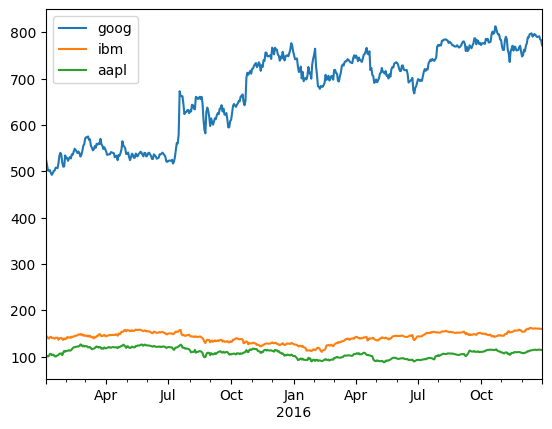

In [2]:
# функция которая делает дату данных по акциям
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)# С помощью  join можно делать рабочий путь до файла
    return df

dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['goog','ibm','aapl']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
print(df)
# стороим гистограмму
df.interpolate().plot()
plt.show()

In [3]:
df.head()

,goog,ibm,aapl
2015-01-02,524.81,145.54,103.50
2015-01-05,513.87,143.24,100.58
2015-01-06,501.96,140.14,100.59
2015-01-07,501.10,139.23,102.01
2015-01-08,502.68,142.26,105.93


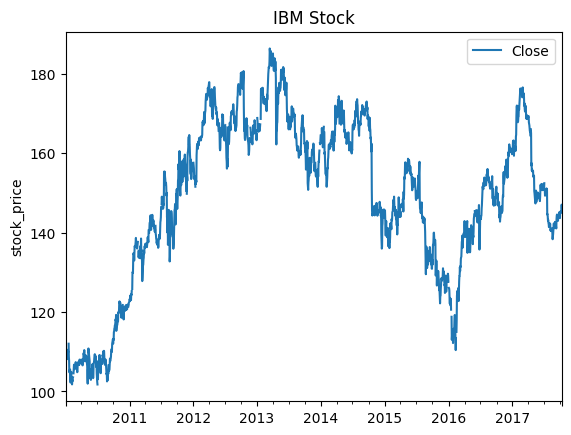

In [4]:
# строим и делаем красоту
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/ibm.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot()
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.show()

In [5]:
df_ibm=df_ibm[['Close']]
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1958 non-null   float64
dtypes: float64(1)
memory usage: 96.2 KB


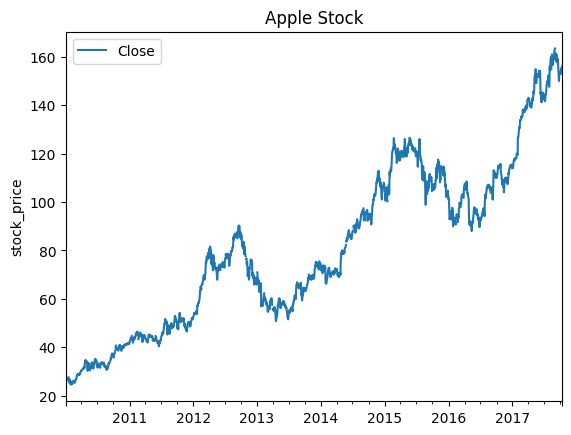

In [6]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_aapl=pd.read_csv("./kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/aapl.us.txt", parse_dates=True, index_col=0)
df_aapl=df1.join(df_aapl)
df_aapl[['Close']].plot()
plt.ylabel("stock_price")
plt.title("Apple Stock")
plt.show()

In [7]:
df_aapl=df_aapl[['Close']]
df_aapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1958 non-null   float64
dtypes: float64(1)
memory usage: 96.2 KB


In [8]:
df_ibm = df_ibm.fillna(method = 'ffill')
df_aapl = df_aapl.fillna(method = 'ffill')

# перобразует в значения от -1 до 1 (типо уменьшает по размеру)
scaler_1 = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler_1.fit_transform(df_ibm['Close'].values.reshape(-1,1))

scaler_2 = MinMaxScaler(feature_range=(-1, 1))
df_aapl['Close'] = scaler_2.fit_transform(df_aapl['Close'].values.reshape(-1,1))

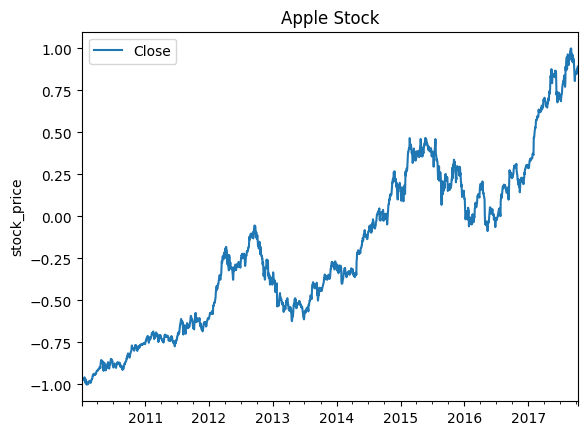

In [9]:
df_aapl=df1.join(df_aapl)
df_aapl[['Close']].plot()
plt.ylabel("stock_price")
plt.title("Apple Stock")
plt.show()

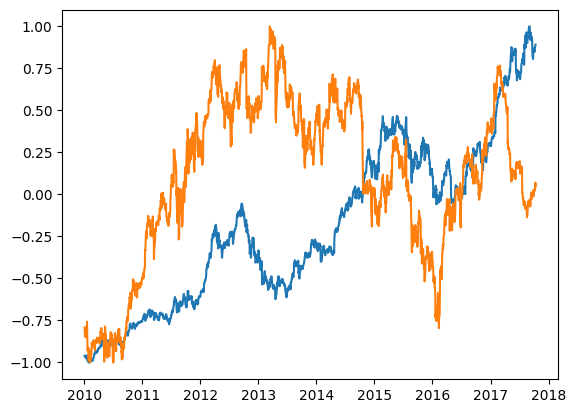

In [10]:
plt.plot(df_aapl['Close'])
plt.plot(df_ibm['Close'])
plt.show()

In [11]:
def load_data_2(stock_1 , stock_2, look_back):
    data_raw_1= stock_1.values
    data_raw_2 = stock_2.values
    data_useful = []
    
    # забиваем дату значениями икс-ов
    for index in range(len(data_raw_1) - look_back - 21): 
        # цикл идет до числа равного длинне data_raw минус look_back
        # look_back это на какой день мы предсказываем назад
        data_1 = []
        data_1.append(data_raw_1[index])
        data_1.append(data_raw_1[index + 7])
        data_1.append(data_raw_1[index + 14])
        data_1.extend(data_raw_1[index+20: index+21+look_back])
                
        data_2 = []  
        # добавляем сначала в новый список нужные значения
        # эти значения типо от предыдущих предсказаний
        data_2.append(data_raw_2[index])
        data_2.append(data_raw_2[index + 7])
        data_2.append(data_raw_2[index + 14])
        data_2.extend(data_raw_2[index+20: index+21+look_back])
        # делаем из списка  массив numpy
        data_2 = np.array(data_2)
        # делаем его на всякий случай -1 на 1
        data_2.reshape(-1,1)
        data_1 = np.array(data_1)
        data_1.reshape(-1,1)
        data_3 = np.hstack((data_1 , data_2))
        # "приклеиваем" дата 2 к основной дате
        data_useful.append(data_3)
        if index == -1:
            print(type(data_raw_1[index:index + look_back]))
            print(data_raw_1[index:index + look_back].shape)
    # делаем из списка  массив numpy
    data_useful = np.array(data_useful);

    test_set_size = int(np.round(0.3 * data_useful.shape[0]));
    train_set_size = data_useful.shape[0] - (test_set_size);
    
    x_train_useful = data_useful[:train_set_size,:-1,:]
    y_train_useful = data_useful[:train_set_size,-1,:]
    
    x_test_useful  = data_useful [train_set_size:,:-1]
    y_test_useful  = data_useful [train_set_size:,-1,:]
    
    return [x_train_useful , y_train_useful , x_test_useful , y_test_useful]

In [12]:
look_back = 2
x_train_useful, y_train_useful, x_test_useful, y_test_useful = load_data_2(df_aapl, df_ibm, look_back)
print('x_train_useful.shape = ',x_train_useful.shape)
print('y_train_useful.shape = ',y_train_useful.shape)
print('x_test_useful.shape = ',x_test_useful.shape)
print('y_test_useful.shape = ',y_test_useful.shape)


x_train_useful.shape =  (1403, 5, 2)
y_train_useful.shape =  (1403, 2)
x_test_useful.shape =  (602, 5, 2)
y_test_useful.shape =  (602, 2)


In [13]:
# Делаем тензоры 
x_train_useful = torch.from_numpy(x_train_useful).type(torch.Tensor)
x_test_useful = torch.from_numpy(x_test_useful).type(torch.Tensor)
y_train_useful = torch.from_numpy(y_train_useful).type(torch.Tensor)
y_test_useful = torch.from_numpy(y_test_useful).type(torch.Tensor)

print(x_train_useful.size(), y_train_useful.size())

n_steps = look_back-1
batch_size = 1606
num_epochs = 3500
#n_iters = 3000
#n_iters / (len(train_X) / batch_size)
#num_epochs = int(num_epochs)

# train_useful = torch.utils.data.TensorDataset(x_train_useful,y_train_useful)
# test_useful = torch.utils.data.TensorDataset(x_test_useful,y_test_useful)

# train_loader_useful = torch.utils.data.DataLoader(dataset=train_useful, 
#                                            batch_size=batch_size, 
#                                            shuffle=False)

# test_loader_useful = torch.utils.data.DataLoader(dataset=test_useful, 
#                                           batch_size=batch_size, 
#                                           shuffle=False)

torch.Size([1403, 5, 2]) torch.Size([1403, 2])


## 3. Build the structure of model

In [14]:
# Build model
#####################
input_dim = 2
hidden_dim = 32
num_layers = 2 
output_dim = 2

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(2, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
10
torch.Size([128, 2])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([2, 32])
torch.Size([2])


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [15]:
# Train model
#####################

hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    #print(type(x_train_aapl))
    # Forward pass
    y_train_pred = model(x_train_useful)

    loss = loss_fn(y_train_pred, y_train_useful)
    
    print(loss)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

tensor(0.3000, grad_fn=<MseLossBackward0>)
tensor(0.2495, grad_fn=<MseLossBackward0>)
tensor(0.2085, grad_fn=<MseLossBackward0>)
tensor(0.1752, grad_fn=<MseLossBackward0>)
tensor(0.1590, grad_fn=<MseLossBackward0>)
tensor(0.1457, grad_fn=<MseLossBackward0>)
tensor(0.1065, grad_fn=<MseLossBackward0>)
tensor(0.0632, grad_fn=<MseLossBackward0>)
tensor(0.0440, grad_fn=<MseLossBackward0>)
tensor(0.0634, grad_fn=<MseLossBackward0>)
tensor(0.0672, grad_fn=<MseLossBackward0>)
Epoch  10 MSE:  0.06722921133041382
tensor(0.0555, grad_fn=<MseLossBackward0>)
tensor(0.0485, grad_fn=<MseLossBackward0>)
tensor(0.0494, grad_fn=<MseLossBackward0>)
tensor(0.0518, grad_fn=<MseLossBackward0>)
tensor(0.0517, grad_fn=<MseLossBackward0>)
tensor(0.0489, grad_fn=<MseLossBackward0>)
tensor(0.0448, grad_fn=<MseLossBackward0>)
tensor(0.0408, grad_fn=<MseLossBackward0>)
tensor(0.0379, grad_fn=<MseLossBackward0>)
tensor(0.0362, grad_fn=<MseLossBackward0>)
Epoch  20 MSE:  0.036247655749320984
tensor(0.0348, grad_fn=<

tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)
Epoch  190 MSE:  0.0015605066437274218
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
Epoch  200 MSE:  0.0013618754455819726
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad

tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
Epoch  370 MSE:  0.0009869408095255494
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
Epoch  380 MSE:  0.0009838504483923316
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad

tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
Epoch  560 MSE:  0.0009556739241816103
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
Epoch  570 MSE:  0.0009546244400553405
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad

tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  730 MSE:  0.0009445889154449105
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  740 MSE:  0.0009439309942536056
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  750 MSE:  0.

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  910 MSE:  0.0009373548673465848
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  920 MSE:  0.0009371088817715645
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1090 MSE:  0.0009336852235719562
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1100 MSE:  0.0009335037902928889
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, gr

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1270 MSE:  0.0009311453904956579
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1280 MSE:  0.0009309247834607959
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, gr

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1450 MSE:  0.0009271350572817028
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1460 MSE:  0.000926888664253056
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, gra

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1630 MSE:  0.0009247348643839359
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1640 MSE:  0.0009244259563274682
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, gr

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1810 MSE:  0.0009176619932986796
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1820 MSE:  0.0009172616992145777
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, gr

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  1990 MSE:  0.0009100673487409949
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
Epoch  2000 MSE:  0.0012833247892558575
tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0009, gr

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
Epoch  2170 MSE:  0.0009531219257041812
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  2180 MSE:  0.0009415510576218367
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, gr

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  2350 MSE:  0.0008876440115272999
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  2360 MSE:  0.0008869789890013635
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, gr

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  2530 MSE:  0.0008761814679019153
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  2540 MSE:  0.0008754327427595854
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, gr

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  2710 MSE:  0.0008641656604595482
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  2720 MSE:  0.0009070187225006521
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0011, gr

tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  2890 MSE:  0.000852117023896426
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch  2900 MSE:  0.0008510703919455409
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, gra

tensor(0.0008, grad_fn=<MseLossBackward0>)
Epoch  3060 MSE:  0.000840431428514421
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
Epoch  3070 MSE:  0.0008389076101593673
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
Epoch  3080 MSE:  

tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
Epoch  3240 MSE:  0.0008298862958326936
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
Epoch  3250 MSE:  0.0008290832629427314
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, gr

tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
Epoch  3420 MSE:  0.0008167337509803474
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
Epoch  3430 MSE:  0.0008116531535051763
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, gr

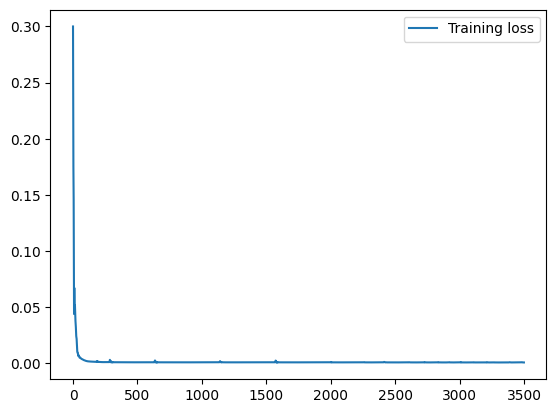

In [16]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

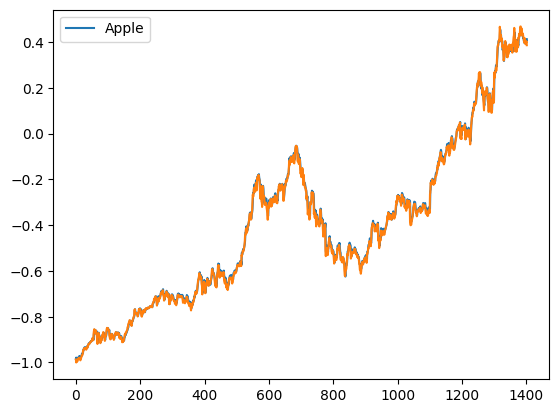

In [37]:
# Cтроим для apple train
plt.plot(y_train_pred.detach().numpy()[:,0], label="Apple")
plt.plot(y_train_useful.detach().numpy()[:,0])
plt.legend()
plt.show()

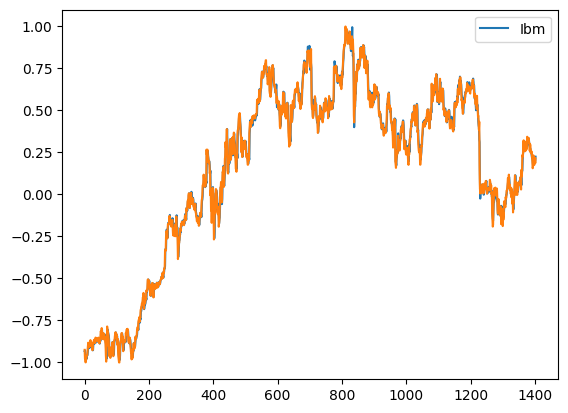

In [38]:
plt.plot(y_train_pred.detach().numpy()[:,1], label="Ibm")
plt.plot(y_train_useful.detach().numpy()[:,1])
plt.legend()
plt.show()

In [39]:
np.shape(y_train_pred)

torch.Size([1403, 2])

In [40]:
y_train_useful.detach().numpy().shape

(1403, 2)

In [41]:
x_train_pred = model(x_train_useful)
x_test_pred = model(x_test_useful)

In [42]:
print(x_train_pred.shape)
print(x_test_pred.shape)

torch.Size([1403, 2])
torch.Size([602, 2])


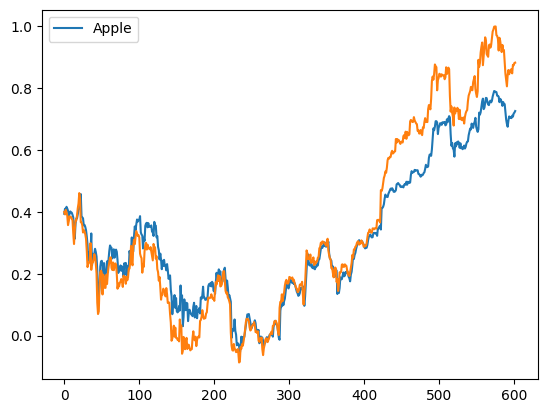

In [43]:
# Строим для apple test
plt.plot(x_test_pred.detach().numpy()[:,0], label="Apple")
plt.plot(y_test_useful.detach().numpy()[:,0])
plt.legend()
plt.show()

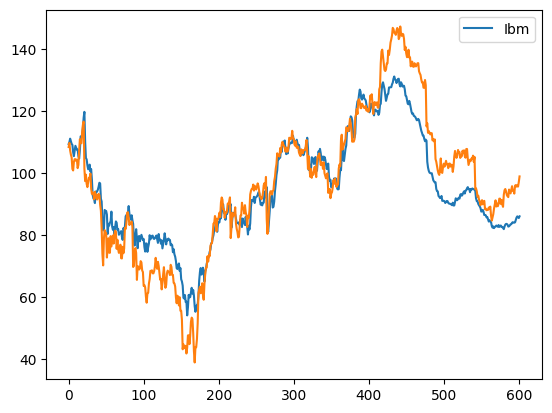

In [44]:
# Строим для apple test
plt.plot(scaler_2.inverse_transform(x_test_pred.detach().numpy()[:,1].reshape(-1, 1)), label="Ibm")
plt.plot(scaler_2.inverse_transform(y_test_useful.detach().numpy()[:,1].reshape(-1, 1)))
plt.legend()
plt.show()

In [45]:
# разделяем на aapl и ibm
y_train_pred_aapl = x_train_pred[:,1]
y_train_pred_ibm = x_train_pred[:,0]
y_test_pred_aapl = x_test_pred[:,1]
y_test_pred_ibm = x_test_pred[:,0]

# делаем reshape
y_train_useful[:,1].detach().numpy().reshape(-1, 1).shape
y_train_pred_aapl.reshape(-1, 1).shape

torch.Size([1403, 1])

In [46]:
y_test_pred_aapl.size()

torch.Size([602])

In [47]:
y_train_pred_aapl.shape

torch.Size([1403])

In [48]:
y_test_pred_aapl.shape

torch.Size([602])

In [49]:
y_train_pred[:2]

tensor([[-0.9843, -0.9318],
        [-0.9786, -0.9277]], grad_fn=<SliceBackward0>)

In [50]:
y_train_useful[:2]

tensor([[-0.9868, -0.9248],
        [-1.0000, -0.9773]])

In [51]:
y_train_pred_aapl[:2]

tensor([-0.9285, -0.9244], grad_fn=<SliceBackward0>)

In [52]:
########################### apple
y_train_pred_aapl = scaler_2.inverse_transform(y_train_pred_aapl.detach().numpy().reshape(-1, 1))
y_test_pred_aapl = scaler_2.inverse_transform(y_test_pred_aapl.detach().numpy().reshape(-1, 1))

# Считаем RMSE корень из средней квадратичной ошибки
trainScore_aapl = math.sqrt(mean_squared_error(scaler_2.inverse_transform(y_train_useful[:,1].detach().numpy().reshape(-1, 1)) , y_train_pred_aapl.reshape(-1, 1)))
print('Train Score Apple: %.2f RMSE' % (trainScore_aapl))
testScore_aapl = math.sqrt(mean_squared_error(scaler_2.inverse_transform(y_test_useful[:,1].detach().numpy().reshape(-1, 1)), y_test_pred_aapl.reshape(-1, 1) ))
print('Test Score Apple: %.2f RMSE' % (testScore_aapl))

########################### ibm
y_train_pred_ibm = scaler_1.inverse_transform(y_train_pred_ibm.detach().numpy().reshape(-1, 1))
y_test_pred_ibm = scaler_1.inverse_transform(y_test_pred_ibm.detach().numpy().reshape(-1, 1))

# Считаем RMSE корень из средней квадратичной ошибки
trainScore_ibm = math.sqrt(mean_squared_error(scaler_1.inverse_transform(y_train_useful[:,1].detach().numpy().reshape(-1, 1)), y_train_pred_ibm.reshape(-1, 1)))
print('Train Score Ibm: %.2f RMSE' % (trainScore_ibm))
testScore_ibm = math.sqrt(mean_squared_error(scaler_1.inverse_transform(y_test_useful[:,1].detach().numpy().reshape(-1, 1)) , y_test_pred_ibm.reshape(-1, 1) ))
print('Test Score Ibm: %.2f RMSE' % (testScore_ibm))

Train Score Apple: 2.60 RMSE
Test Score Apple: 8.58 RMSE
Train Score Ibm: 30.91 RMSE
Test Score Ibm: 18.67 RMSE


In [53]:
scaler_1.inverse_transform(y_test_useful[:,1].detach().numpy().reshape(-1, 1))[:5]

array([[152.81999],
       [153.63   ],
       [152.14   ],
       [151.33   ],
       [150.77   ]], dtype=float32)

In [54]:
y_test_pred_ibm.reshape(-1, 1)[:5]

array([[160.72205],
       [161.40887],
       [160.93918],
       [161.67618],
       [161.43593]], dtype=float32)

[[        nan]
 [        nan]
 [29.55646515]
 ...
 [        nan]
 [        nan]
 [        nan]]


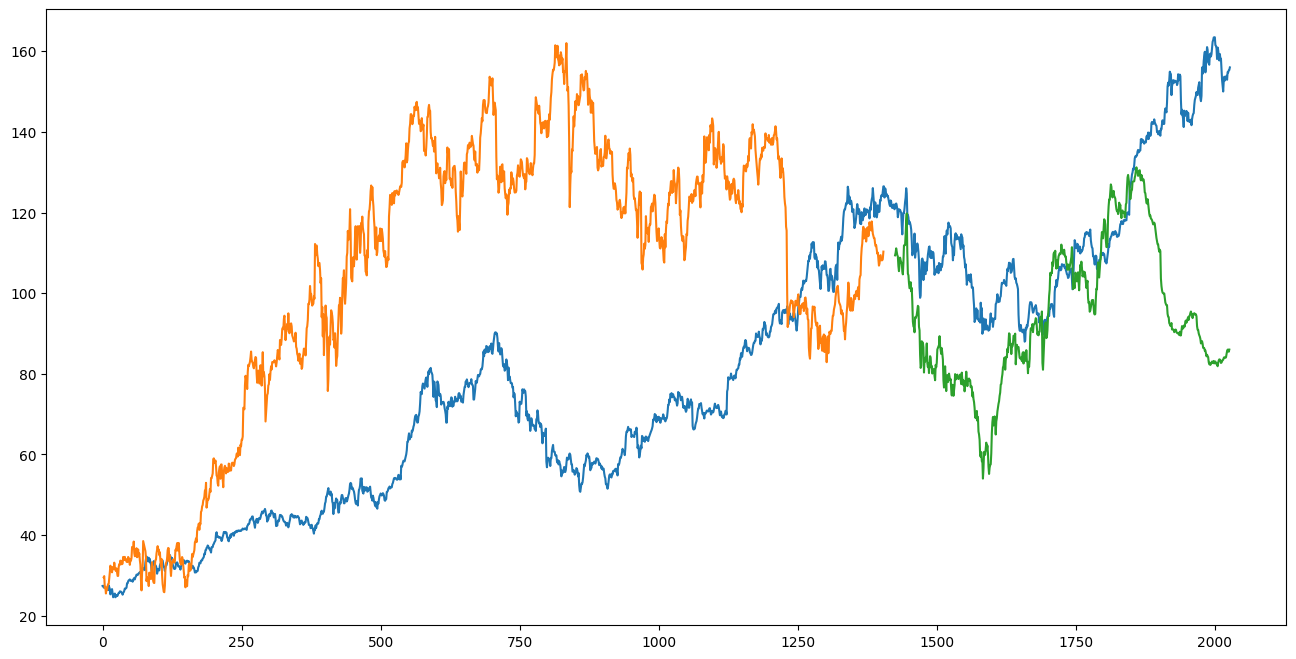

In [55]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_aapl)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred_aapl)+look_back, :] = y_train_pred_aapl

print(trainPredictPlot)
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_aapl)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred_aapl)+ 21 +look_back-1:len(df_aapl)-1, :] = y_test_pred_aapl

# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(scaler_2.inverse_transform(df_aapl))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


[[         nan]
 [         nan]
 [102.33635712]
 ...
 [         nan]
 [         nan]
 [         nan]]


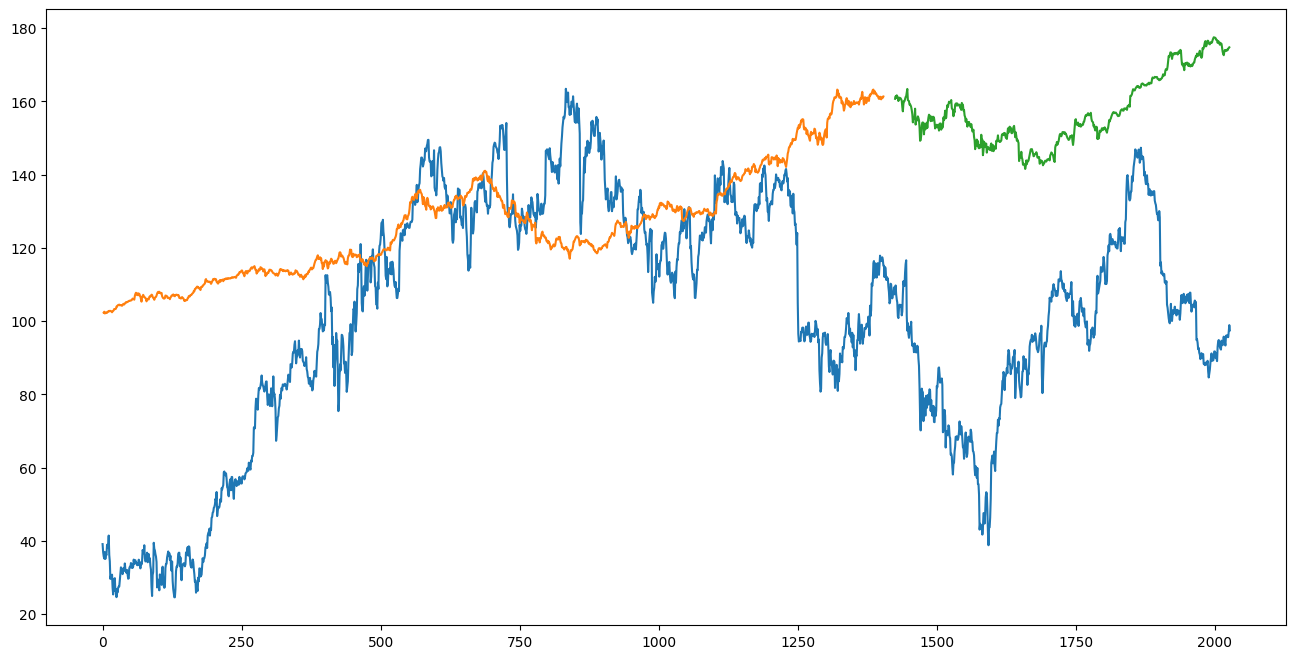

In [36]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred_aapl)+look_back, :] = y_train_pred_ibm

print(trainPredictPlot)
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred_ibm)+ 21 +look_back-1:len(df_ibm)-1, :] = y_test_pred_ibm

# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(scaler_2.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()